In [3]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
import datetime
import pandas as pd
import numpy as np
from functools import partial
from dateutil import parser as dtparser

from utils.datafetch import *
from utils.vectorized_funs import *
from utils.datapipe import *
from utils.kerasutil import *
from FintechCapstone import FinCapstone

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from __future__ import print_function

%matplotlib inline

plt.style.use('seaborn-whitegrid')

In [126]:
date_from = '2009-01-01'
date_to = '2017-03-01'
timespan = {
    "short_term": [1, 5]
    ,"medium_term": [40]
    ,"long_term": [90]
}

timespan_ab = {
    "short_term": []
    ,"medium_term": [30]
    ,"long_term": []
}

trial = FinCapstone(ticker_list=["ZHNE","BSFT","AERO","MATR","ITMSF","FIT","TIPT","TSRE","OLBK","QADA","ATTU","LGF","STX","TPCS","GSAT","ZNGA","GLW","HIMX","YHOO", "NWSA","JAKK","GLUU","AMZN", "AAPL", "EBAY", "GOOG", "DIS", "NFLX", "EA", "TWTR", "FB", "TTWO", "PXLW", "UBI"], ticker_list_samplesize=4, timespan=timespan, timespan_ab=timespan_ab, date_from=date_from)
#trial = FinCapstone(ticker_list_samplesize=200, timespan=timespan, timespan_ab=timespan_ab, date_from=date_from)

#trial.run_initial_dataload()
#trial.feature_engineering()

- ~~Open~~
- ~~Close~~
- ~~High~~
- ~~Low~~
- ~~Volume~~

In [54]:
_ticker = "NFLX"
_slice_limit = -252 * 2

def load_dataframes(ticker, limit):
    #Load Dataframes
    raw_df = load_raw_frame(ticker, tryfetch=True)
    sma_df = calc_sma(raw_df, {"short": [5,10,30,60,90,200]}, ["Close", "Open", "High", "Low", "Volume"], merge_result=False)
    boll_df = calc_bollinger(raw_df, {"long_term": [5,10,30,60,90,200]}, ["Close", "Open", "High", "Low", "Volume"], merge_result=False)

    sma_df.set_index(raw_df["Date"], inplace=True)
    boll_df.set_index(raw_df["Date"], inplace=True)
    raw_df.set_index("Date", inplace=True)

    raw_df = raw_df.iloc[limit:]
    sma_df = sma_df.iloc[limit:]
    boll_df = boll_df.iloc[limit:]
    
    baseline_X = trial.load_baseline_features(ticker, parseDate=True)
    baseline_X.set_index("Date", inplace=True)
    baseline_X = baseline_X.iloc[limit:]
    baseline_y = trial.load_baseline_labels(ticker, parseDate=True)
    baseline_y.set_index("Date", inplace=True)
    baseline_y = baseline_y.iloc[limit:]
    
    return raw_df, sma_df, boll_df, baseline_X, baseline_y

raw_df, sma_df, boll_df, baseline_X, baseline_y = load_dataframes(_ticker, _slice_limit)

In [55]:
def plot_prices(raw_df, column_name="Close", formatmask="-g"):
    if raw_df is None:
        raw_df, sma_df, boll_df = load_dataframes(ticker, limit)

    # get our x ticks
    x = raw_df.index.tolist()

    # setup figure
    fig = plt.figure(figsize=(15, 6))
    grid = plt.GridSpec(4, 4, hspace=0.2, wspace=0.2)

    volume_hist = fig.add_subplot(grid[-1:,:])
    main_ax = fig.add_subplot(grid[:-1, :], sharex=None)


    #Main Plot
    main_ax.plot(x, raw_df[column_name], formatmask, label=column_name)


    #Volume Plot
    volume_hist.bar(x, raw_df["Volume"], label="Volume")

    #setting legends
    main_ax.legend(prop={'size':11})
    volume_hist.legend(prop={'size':11})


    # rotating ticks
    for tick in volume_hist.get_xticklabels():
        tick.set_rotation(30)


    plt.show()

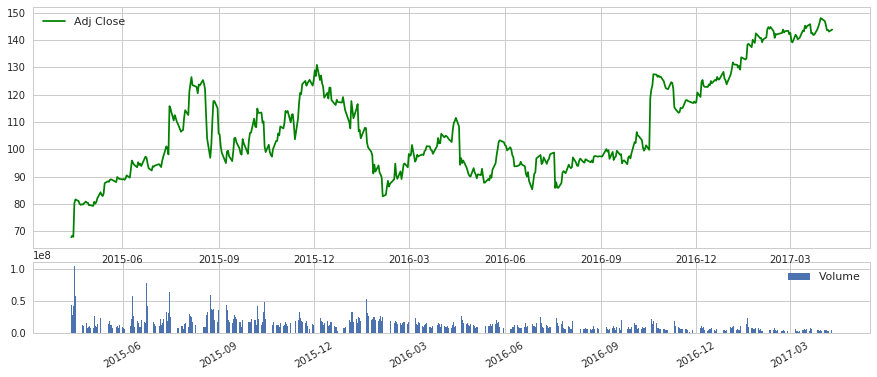

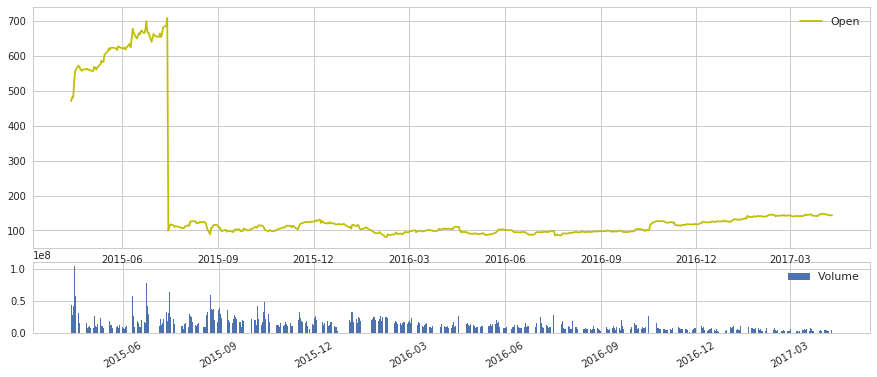

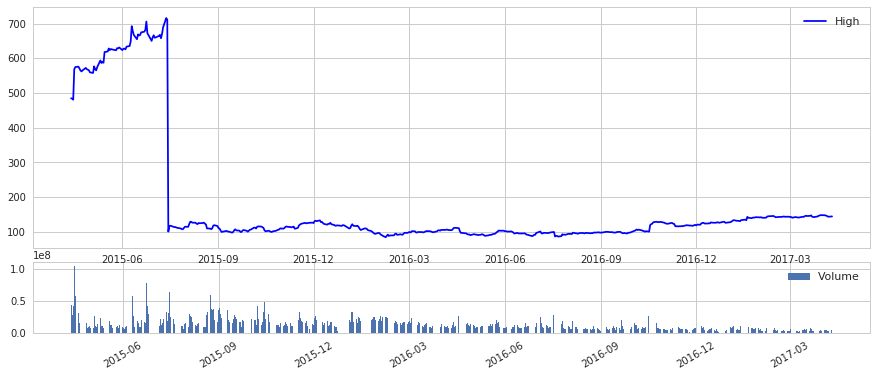

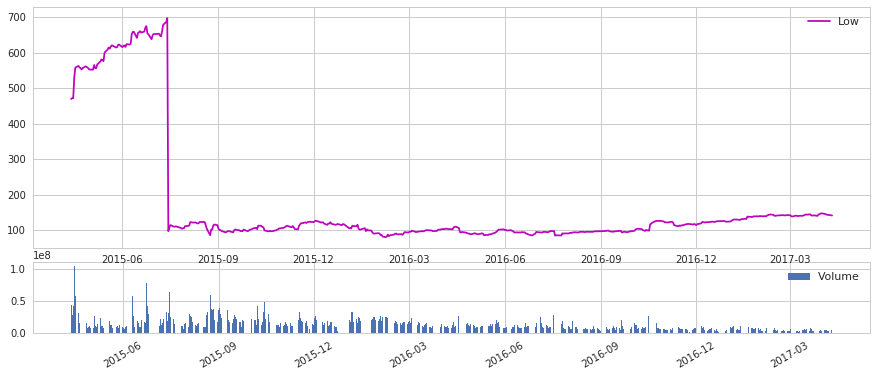

In [59]:
plot_prices(raw_df, "Close", "-g")
plot_prices(raw_df, "Open", "-y")
plot_prices(raw_df, "High", "-b")
plot_prices(raw_df, "Low", "-m")

In [57]:
def plot_deltas(raw_df, baseline_X, baseline_y, column_name="Close", formatmask="-g"):
    if raw_df is None:
        raw_df, sma_df, boll_df = load_dataframes(ticker, limit)

    # get our x ticks
    x = raw_df.index.tolist()

    # setup figure
    fig = plt.figure(figsize=(15, 8))
    grid = plt.GridSpec(5, 4, hspace=0.2, wspace=0.2)

    delta_ax = fig.add_subplot(grid[0, :])
    main_ax = fig.add_subplot(grid[1:3, :], sharex=delta_ax)
    volume_hist = fig.add_subplot(grid[3,:], sharex=delta_ax)
    cumdelta_ax = fig.add_subplot(grid[4,:], sharex=delta_ax)
    
    delta = None
    if column_name == "Close":
        delta = baseline_y["timewindow_return_1_Close"]
    else:
        delta = baseline_X["timewindow_return_1_{}".format(column_name)]

    
    delta_ax.plot(x, delta, "-k", label="1D return", linewidth=0.3)
    
    #Main Plot
    main_ax.plot(x, raw_df[column_name], formatmask, label=column_name)

    #Volume Plot
    volume_hist.bar(x, raw_df["Volume"], label="Volume")
    
    cumdelta_ax.plot(x, delta.cumsum(), "-b", label="Cum. return")

    #setting legends
    main_ax.legend(prop={'size':11})
    volume_hist.legend(prop={'size':11})
    delta_ax.legend(prop={'size':11})
    cumdelta_ax.legend(prop={'size':11})
    


    plt.show()


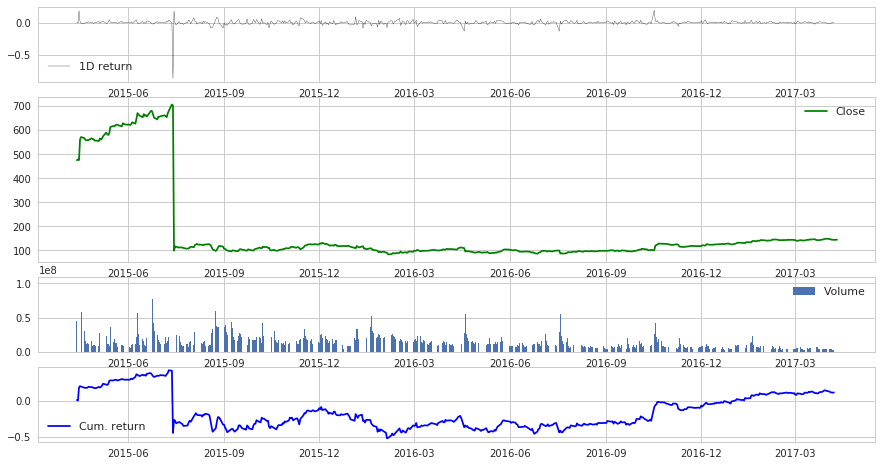

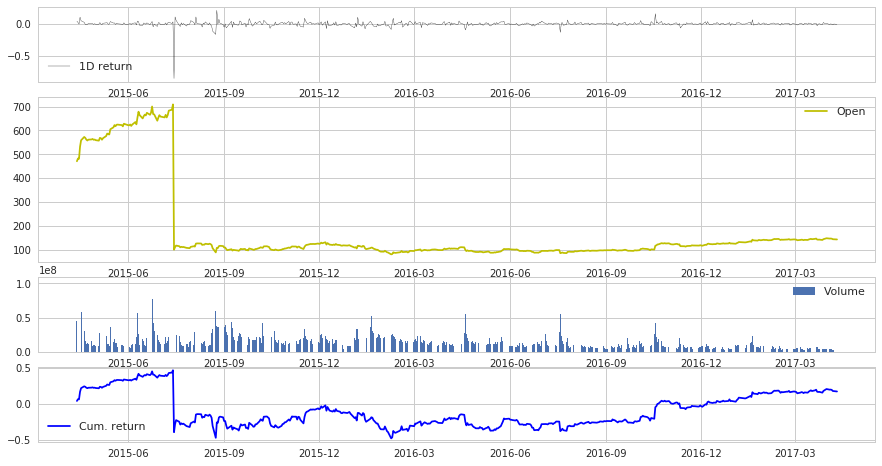

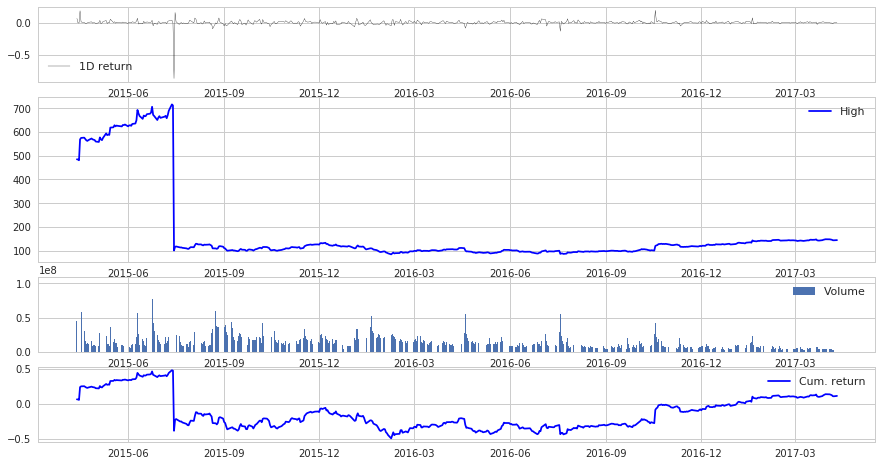

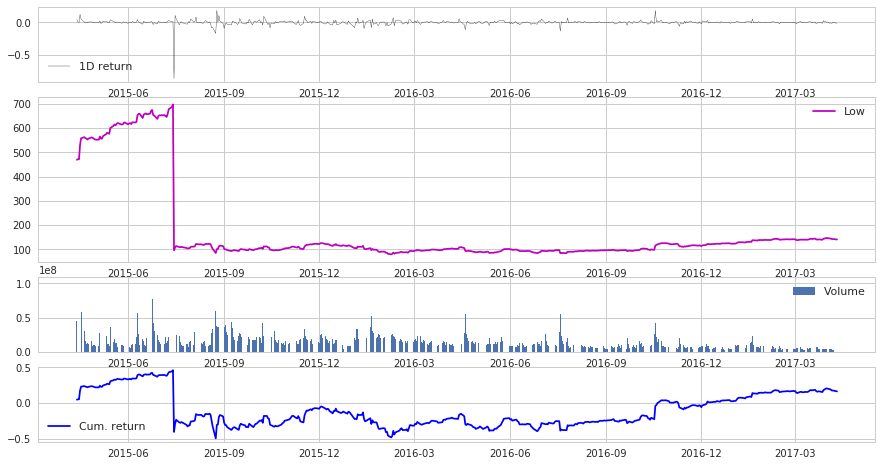

In [58]:
plot_deltas(raw_df, baseline_X, baseline_y, "Close", "-g")
plot_deltas(raw_df, baseline_X, baseline_y, "Open", "-y")
plot_deltas(raw_df, baseline_X, baseline_y, "High", "-b")
plot_deltas(raw_df, baseline_X, baseline_y, "Low", "-m")

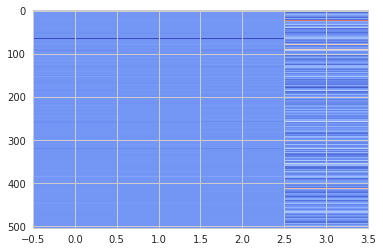

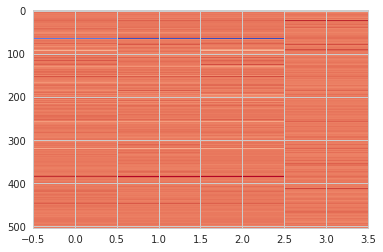

In [117]:
normbaseline_X = baseline_X / baseline_X.max()

plt.imshow(baseline_X.values, aspect='auto', interpolation='nearest', cmap="coolwarm")
plt.show()
plt.imshow(normbaseline_X.values, aspect='auto', interpolation='nearest', cmap="coolwarm")
plt.show()